In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat
from scipy.sparse.linalg import svds, bicg, inv, LinearOperator
from scipy.sparse import diags
from scipy.linalg import pinv
from gc import collect

## X-ray tomography

In [2]:
H = loadmat('data/H.mat')
x = loadmat('data/x.mat')
H, x = H['H'], x['x']

In [3]:
H.shape

(16200, 8100)

In [4]:
x.shape

(8100, 1)

In [5]:
y_size = (H@x).shape[0]
sigma = 1
y = H@x + np.random.normal(0, sigma, y_size).reshape((y_size, 1))

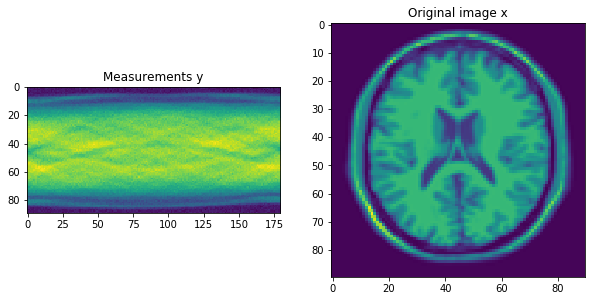

In [6]:
y_2d, x_2d = y.reshape((90, 180), order='F'), x.reshape((90, 90), order='F')

fig = plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(y_2d)
plt.title(r'Measurements y')

plt.subplot(122)
plt.imshow(x_2d)
plt.title(r'Original image x')

plt.show()

## Optimization problem

In [7]:
G = loadmat('data/G.mat')
G = G['G']

In [8]:
G.shape

(16200, 8100)

We want to minimize the following cost function

\begin{align}
f &\longrightarrow \mathbb{R}^N \\
x &\longmapsto \frac{1}{2}||Hx - y||^2 + \lambda r(x)
\end{align}

Where 

\begin{align}
r &\longrightarrow \mathbb{R} \\
x &\longmapsto \sum_{n=0}^{2N-1}\psi \left( \left[ Gx \right]^{(n)} \right)
\end{align}

$G \in \mathbb{R}^{2N \times N}$ is the gradient matrix, it computes the horizontal and vertical gradients of the image, and

\begin{align}
\psi &\longrightarrow \mathbb{R} \\
u &\longmapsto \sqrt{1 + \frac{u^2}{\delta^2}}
\end{align}

with $\delta > 0$

In [9]:
lambd, delta = 0.13, 0.02
psi = lambda u : np.sqrt(1 + u**2/(delta**2))
f = lambda x : (np.linalg.norm(H@x - y)**2)/2 + lambd*psi(G@x).sum()

### Expression of $\nabla f$

Let $x \in \mathbb{R}^N$, we have

$$
\nabla r(x) = \sum_{n=0}^{2N-1}\nabla \left[Gx \right]^{(n)}\psi'\left( \left[Gx \right]^{(n)} \right)
$$

With $\forall{u} \in \mathbb{R} : \psi'(u) = \frac{u}{\delta^2}\left( 1 + \frac{u^2}{\delta^2} \right)^{-\frac{1}{2}}$, and we have the following for $\left[Gx \right]^{(n)}$ and $\nabla \left[Gx \right]^{(n)}$

\begin{align}
\left[Gx \right]^{(n)} &= <Gx, e_n >\\
                       &= <x, G^Te_n> \\
\nabla \left[Gx \right]^{(n)} &= G^Te_n\\          
\end{align}

We have then

$$
\nabla r(x) = \sum_{n=0}^{2N-1}\psi'\left(\left[ Gx\right]^{(n)} \right)G^Te_n
$$

Which means that:

\begin{align}
\nabla f(x) &= H^T\left( Hx - y \right) + \lambda \sum_{n=0}^{2N-1}\psi'\left(\left[ Gx\right]^{(n)} \right)G^Te_n \\
            &= H^T\left( Hx - y \right) + \lambda G^T \psi'\left( \left[Gx \right] \right)
\end{align}

With

$$
\psi'\left( \left[Gx \right] \right) =
\begin{bmatrix}
    \psi'\left( \left[Gx \right]^{(0)} \right) \\
    \vdots \\
    \psi'\left( \left[Gx \right]^{(2N-1)} \right)
\end{bmatrix}
$$


In [10]:
psi_grad = lambda u : (u/(delta**2))*1/np.sqrt((1 + u**2/(delta**2)))
f_grad = lambda x : H.T@(H@x - y) + lambd*G.T@psi_grad(G@x)

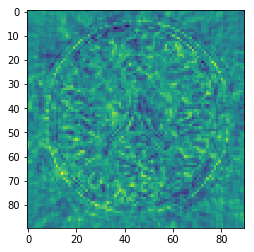

In [11]:
plt.imshow(f_grad(x).reshape((90, 90), order = 'F'))
plt.show()

Let's prove that $\nabla f$ is Lipschitz with constant $L = ||H||^2 + \frac{\lambda}{\delta^2}||G||^2$

We have

\begin{align}
\forall{x_1, x_2} \in \mathbb{R}^N : ||H^T\left( Hx_1 - y \right) - H^T\left( Hx_2 - y \right)|| &= ||H||||H\left( x_1 - x_2\right)|| \\
&= ||H||^2||x_1 - x_2||
\end{align}
If we prove that $\psi'$ is Lipschitz with constant $\frac{1}{\delta^2}$ then:

\begin{align}
\forall{x_1, x_2} \in \mathbb{R}^N : ||\nabla f (x_1) - \nabla f (x_2)|| &= ||H^TH\left( x_1 - x_2 \right) + \lambda G^T\left(\psi'\left( Gx_1 \right) - \psi'\left( Gx_2 \right) \right)|| \\
& \le ||H||^2||x_1 - x_2|| + \lambda||G||||\psi'\left(Gx_1 \right) - \psi'\left(Gx_2 \right)||\\
& \le ||H||^2||x_1 - x_2|| + \frac{\lambda}{\delta^2}||G||^2||x_1 - x_2|| \\
& \le \left(||H||^2 + \frac{\lambda}{\delta^2}||G||^2 \right)||x_1 - x_2||
\end{align}

Therfore $\nabla f$ is Lipschitz with constant $L = ||H||^2 + \frac{\lambda}{\delta^2}||G||^2$


In [12]:
def f_grad_lip(lambd, delta):
    u_G, s_G, vt_G = svds(G)
    u_H, s_H, vt_H = svds(H)
    return max(s_H)**2 + (lambd/(delta**2))*max(s_G)**2

L = f_grad_lip(lambd, delta)

print('lambda = %.2f , delta = %.2f -> L = %.2f' %(lambd, delta, L))

lambda = 0.13 , delta = 0.02 -> L = 18092.77


## Optimization algorithms

### Gradient descent algorithm

In [13]:
gamma = 1e-4
def gradient_descent(f, epsilon, nit, grad_criterion = False):
    
    xn = np.zeros((x.shape[0], 1))
    fxn = f(xn)
    results = [[xn, fxn]]
    converged = False
    i = 0
    while (not converged) and (i < nit):
        grad = f_grad(xn)
        xn_1 = xn - gamma*grad
        fxn_1 = f(xn_1)
        results.append([xn_1, fxn_1])
        converged = (np.linalg.norm(grad) <= epsilon) if grad_criterion else np.isclose(fxn, fxn_1, rtol=epsilon)
        fxn, xn = fxn_1, xn_1
        i += 1
        if i%100 == 0:
            print(i)
            
    return results, converged, i


In [22]:
results, converged, it = gradient_descent(f, np.sqrt(x.shape[0])*(10**(-4)), 3e3, grad_criterion = True)
# results, converged, it = gradient_descent(f, 1e-7, 2e3)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


convergence            :  True
Number of iterations   :  2640
evaluation             :  13002.23972924806


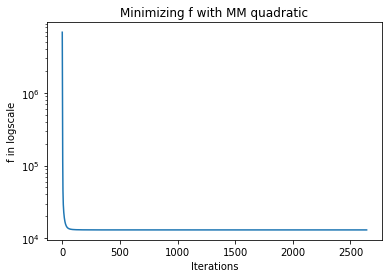

In [23]:
fs = [result[1] for result in results]
print('convergence            : ', converged)
print('Number of iterations   : ', it)
print('evaluation             : ', fs[-1])
plt.plot(range(len(fs)), fs)
plt.yscale('log')
plt.title('Minimizing f with MM quadratic')
plt.ylabel('f in logscale')
plt.xlabel('Iterations')
plt.show()

### MM quadratic algorithm

We have that $f$ is twice-differentiable on $\mathbb{R}^N$, we know that there exists a semi-difinite matrix $A \in \mathbb{R}^{N\times N}$ such that 

\begin{equation}
\forall{y}\in \mathbb{R}^N, \forall{x}\in \mathbb{R}^N : h(x, y) = f(y) + <\nabla f(y)|x-y> + \frac{1}{2}<x-y|A(x-y)>
\end{equation}

Let's put

\begin{align}
h : \mathbb{R}^N &\longrightarrow \mathbb{R} \\
    x &\longmapsto \frac{1}{2}||Hx - y||^2
\end{align}

With:

\begin{align}
\nabla h (x) &= H^T\left( Hx - y \right) \\
\nabla^2 h (x) &= H^TH
\end{align}

With Taylor second order development we have:

$$
\forall{x_1, x_2} \in \mathbb{R}^N : h(x_1) \le h(x_2) + <H^T\left( Hx_2 - y \right)|x_1 - x_2> + \frac{1}{2}<x_1-x_2|H^TH(x_1-x_2)>
$$

We have $\psi$ is even, differentiable, and $\forall{u} \in \mathbb{R} : \psi\left( \sqrt{u} \right) = \sqrt{1 + \frac{u}{\delta^2}}$ is differentiable on $\mathbb{R}_{+}^*$, $\forall{u} \in \mathbb{R}_+ : \psi'\left( u \right) = \frac{u}{\delta^2\sqrt{1 + \frac{u^2}{\delta^2}}} \ge 0$ and $w(u) = \frac{\psi'(u)}{u} \underset{u \rightarrow 0^+}{\longrightarrow} \in \mathbb{R}$

Therfore we get:

\begin{align}
\psi(x) &\le \psi(y) + \psi'\left( y \right)\left( x - y \right) + \frac{1}{2}w(y)\left( x - y \right)^2 \\
        &\le \psi(y) + \psi'\left( y \right)\left( x - y \right) + \frac{1}{2\delta^2\sqrt{1 + \frac{y^2}{\delta^2}}}\left( x - y \right)^2
\end{align}



\begin{align}
\forall{u, v}\in \mathbb{R}^N : r(u) \le \sum_{n=0}^{2N-1} \left[ \psi(G[u]^{(n)}) + \psi'\left( G[v]^{(n)} \right)\left( [Gu]^{(n)} - G[v]^{(n)} \right) + \frac{1}{2\delta^2\sqrt{1 + \frac{\left(G[v]^{(n)}\right)^2}{\delta^2}}}\left( [Gu]^{(n)} - [Gv]^{(n)} \right)^2 \right]
\end{align}

\begin{align}
\forall{u, v}\in \mathbb{R}^N f(u) \le h(u, v)
\end{align}

We can set 
$$
\forall{u, v}\in \mathbb{R}^N h(u, v) = h(v) + <H^T\left( Hv - y \right)|u - v> + \frac{1}{2}<u-v|H^TH(u-v)>  + \sum_{n=0}^{2N-1} \left[ \psi([Gv]^{(n)}) + \psi'\left( [Gv]^{(n)} \right)\left( [Gu]^{(n)} - [Gv]^{(n)} \right) + \frac{w\left( [Gv]^{(n)} \right)}{2}\left( [Gu]^{(n)} - [Gv]^{(n)} \right)^2 \right]
$$

We deduce that :

$$
\forall{v}\in \mathbb{R}^n A(v) = H^TH + \lambda G^T W\left( v \right) G
$$

With

$$
W\left( v \right) = diag\left( w\left( G[v]^{(0)} \dots G[v]^{(2N-1)} \right) \right)
$$

In [14]:
w = lambda v : lambd/(delta**2*(np.sqrt(1 + v**2/(delta**2))))

In [15]:
def mm_quad(f, epsilon, nit, grad_criterion = False):
    xn = np.zeros((x.shape[0], 1))
    fxn = f(xn)
    results = [[xn, fxn]]
    converged = False
    i = 0
    while (not converged) and (i < nit):
        test = lambda v : H.T@(H@v) + G.T@(diags(w(G@xn.flatten())))@(G@v)
        B = LinearOperator((8100, 8100), matvec = test, rmatvec = test)
        grad = f_grad(xn)
        xn_1 = xn - bicg(B, grad)[0].reshape(-1, 1)
        fxn_1 = f(xn_1)
        results.append([xn_1, fxn_1])
        converged = (np.linalg.norm(grad) <= epsilon) if grad_criterion else np.isclose(fxn, fxn_1, rtol=epsilon)
        fxn, xn = fxn_1, xn_1
        i += 1
        if i%10 == 0:
            print(i)
            
    return results, converged, i


In [28]:
# results, converged, it = mm_quad(f, 1e-7, 50)
results, converged, it = mm_quad(f, np.sqrt(x.shape[0])*(10**(-4)), 3e3, grad_criterion = True)

10
20
30
40
50
60


convergence            :  True
Number of iterations   :  67
evaluation             :  13002.23972837436


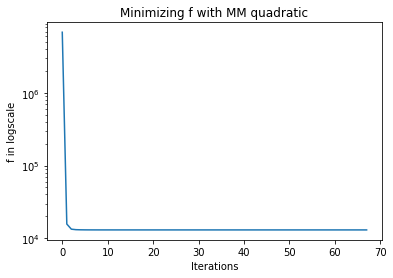

In [29]:
fs = [result[1] for result in results]
print('convergence            : ', converged)
print('Number of iterations   : ', it)
print('evaluation             : ', fs[-1])
plt.plot(range(len(fs)), fs)
plt.yscale('log')
plt.title('Minimizing f with MM quadratic')
plt.ylabel('f in logscale')
plt.xlabel('Iterations')
plt.show()

### 3MG algorithm

In [16]:
def mm_mg(f, epsilon, nit, grad_criterion = False):
    xn = np.zeros_like(x)
    fxn = f(xn)
    results = [[xn, fxn]]
    converged = False
    Dn = -f_grad(xn)
    i = 0
    while (not converged) and (i < nit):
        H_D, G_D = H@Dn, G@Dn
        u = pinv((H_D.T@H_D + lambd*G_D.T@diags(w(G@xn.flatten()))@G_D))@(Dn.T@(Dn[:, 0]))
        xn_1 = xn + Dn@u.reshape(-1, 1)
        Dn = np.hstack([-f_grad(xn_1), xn_1 - xn])
        fxn_1 = f(xn_1)
        results.append([xn_1, fxn_1])
        converged = (np.linalg.norm(Dn[:, 0]) <= epsilon) if grad_criterion else np.isclose(fxn, fxn_1, rtol=epsilon)
        fxn, xn = fxn_1, xn_1
        i += 1
        if i%10 == 0:
            print(i)
            
    return results, converged, i


In [35]:
# results, converged, it = mm_mg(f, 1e-7, 100)
results, converged, it = mm_mg(f, np.sqrt(x.shape[0])*(10**(-4)), 3e3, grad_criterion = True)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


convergence            :  True
Number of iterations   :  144
evaluation             :  13002.23972765656


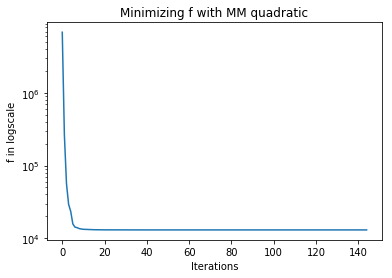

In [36]:
fs = [result[1] for result in results]
print('convergence            : ', converged)
print('Number of iterations   : ', it)
print('evaluation             : ', fs[-1])
plt.plot(range(len(fs)), fs)
plt.yscale('log')
plt.title('Minimizing f with MM quadratic')
plt.ylabel('f in logscale')
plt.xlabel('Iterations')
plt.show()

### Block coordinate MM quadratic

In order to have $\mathbb{J}_j = \{ N_j(j-1) + 1, \dots, N_j \}$, the blocks must have the same size $N_j$

In [40]:
collect()

0

In [17]:
ht_h = H.T@H

In [18]:
block = lambda v, J, j : ht_h[(j-1)*(v.shape[0]//J) : j*(v.shape[0]//J), (j-1)*(v.shape[0]//J) : j*(v.shape[0]//J)] + (G.T@(diags(w(G@v.flatten())))@G)[(j-1)*(v.shape[0]//J) : j*(v.shape[0]//J), (j-1)*(v.shape[0]//J) : j*(v.shape[0]//J)]

In [19]:
collect()

3294

In [20]:
# def mm_block(f, epsilon, nit, K = 5):
#     Nj = x.shape[0]//K
#     xn = np.zeros_like(x)
#     fxn = f(xn)
#     results = [[xn, fxn]]
#     converged = False
#     i = 0
#     while (not converged) and (i < nit):
#         j = i%K + 1
#         x_block = np.zeros_like(xn)
#         x_block[(j-1)*Nj : j*Nj, 0] = bicg(block(xn, K, j), f_grad(xn)[(j-1)*Nj : j*Nj])[0]
#         xn_1 = xn - x_block
#         fxn_1 = f(xn_1)
#         results.append([xn_1, fxn_1])
#         converged = np.isclose(fxn, fxn_1, rtol=epsilon)
#         fxn, xn = fxn_1, xn_1
#         i += 1
# #         if i%10 == 0:
# #             print(i)
            
#     return results, converged, i

def mm_block(f, epsilon, nit, K = 5, grad_criterion = False):
    Nj = x.shape[0]//K
    xn = np.zeros_like(x)
    fxn = f(xn)
    results = [[xn, fxn]]
    converged = False
    i = 0
    while (not converged) and (i < nit):
        j = i%K + 1
        x_block = np.zeros_like(xn)
        grad = f_grad(xn)
        x_block[(j-1)*Nj : j*Nj, 0] = bicg(block(xn, K, j), grad[(j-1)*Nj : j*Nj])[0]
        xn_1 = xn - x_block
        fxn_1 = f(xn_1)
        results.append([xn_1, fxn_1])
        converged = (np.linalg.norm(grad) <= epsilon) if grad_criterion else np.isclose(fxn, fxn_1, rtol=epsilon)
        fxn, xn = fxn_1, xn_1
        i += 1
        if i%10 == 0:
            print(i)
            
    return results, converged, i


In [21]:
results, converged, it = mm_block(f, np.sqrt(x.shape[0])*(10**(-4)), 3e3, grad_criterion = True, K = 8)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

convergence            :  False
Number of iterations   :  3000
evaluation             :  13092.228951903828


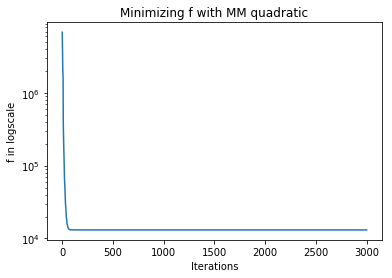

In [22]:
fs = [result[1] for result in results]
print('convergence            : ', converged)
print('Number of iterations   : ', it)
print('evaluation             : ', fs[-1])
plt.plot(range(len(fs)), fs)
plt.yscale('log')
plt.title('Minimizing f with MM quadratic')
plt.ylabel('f in logscale')
plt.xlabel('Iterations')
plt.show()

In [19]:
collect()

0

3
5
6
9


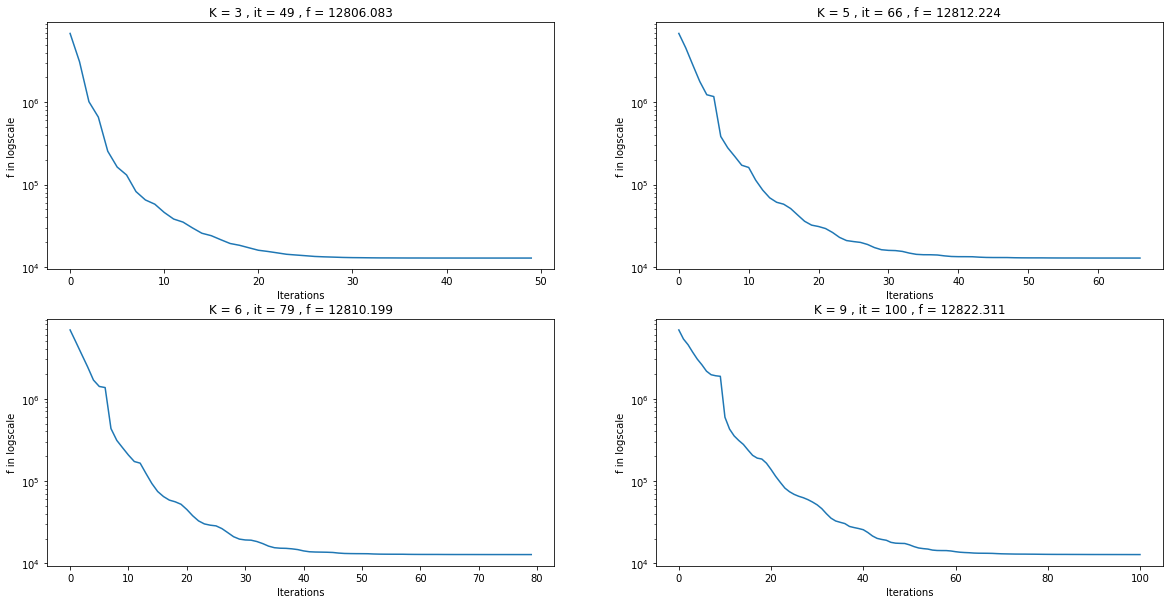

In [35]:
K_grid = [3, 5, 6, 9]

fig = plt.figure(figsize=(20, 10))

for i, K in enumerate(K_grid):
    
    plt.subplot(2, 2, i+1)
    print(K)
    results, converged, it = mm_block(f, 1e-5, 100, K)
    fs = [result[1] for result in results]
    plt.plot(range(len(fs)), fs)
    plt.yscale('log')
    plt.title('K = %d , it = %d , f = %.3f' %(K, it, fs[-1]))
    plt.ylabel('f in logscale')
    plt.xlabel('Iterations')
    

### Parallel MM quadratic algorithm

In [25]:
H_new, G_new = diags(np.array(H.sum(axis = 1)).flatten())*H, diags(np.array(G.sum(axis = 1)).flatten())*G

In [26]:
H_new.shape

(16200, 8100)

In [30]:
# def mm_quad_diag(f, epsilon, nit):
#     xn = np.zeros((x.shape[0], 1))
#     fxn = f(xn)
#     results = [[xn, fxn]]
#     converged = False
#     i = 0
#     while (not converged) and (i < nit):
#         B = diags(H_new.T@np.ones(H_new.shape[0]) + lambd*G_new.T@w(G_new@xn.flatten()))
#         xn_1 = xn - bicg(B, f_grad(xn))[0].reshape(-1, 1)
#         fxn_1 = f(xn_1)
#         results.append([xn_1, fxn_1])
#         converged = np.isclose(fxn, fxn_1, rtol=epsilon)
#         fxn, xn = fxn_1, xn_1
#         i += 1
#         if i%100 == 0:
#             print(i)
            
#     return results, converged, i

def mm_quad_diag(f, epsilon, nit, grad_criterion = False):
    xn = np.zeros((x.shape[0], 1))
    fxn = f(xn)
    results = [[xn, fxn]]
    converged = False
    i = 0
    while (not converged) and (i < nit):
        B = diags(H_new.T@np.ones(H_new.shape[0]) + lambd*G_new.T@w(G_new@xn.flatten()))
        grad = f_grad(xn)
        xn_1 = xn - bicg(B, grad)[0].reshape(-1, 1)
        fxn_1 = f(xn_1)
        results.append([xn_1, fxn_1])
        converged = (np.linalg.norm(grad) <= epsilon) if grad_criterion else np.isclose(fxn, fxn_1, rtol=epsilon)
        fxn, xn = fxn_1, xn_1
        i += 1
        if i%100 == 0:
            print(i)
            
    return results, converged, i

In [33]:
results, converged, it = mm_quad_diag(f, np.sqrt(x.shape[0])*(10**(-4)), 10e3, grad_criterion = True)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300


convergence            :  True
Number of iterations   :  4313
evaluation             :  13091.657680932454


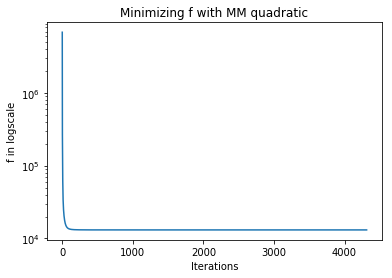

In [34]:
fs = [result[1] for result in results]
print('convergence            : ', converged)
print('Number of iterations   : ', it)
print('evaluation             : ', fs[-1])
plt.plot(range(len(fs)), fs)
plt.yscale('log')
plt.title('Minimizing f with MM quadratic')
plt.ylabel('f in logscale')
plt.xlabel('Iterations')
plt.show()

### Comparison of the methods

Here we will rewrite the algorithms with the new stopping criterion:

$$
||\nabla f(x_k)|| \le \sqrt{N}\times 10^{-4}
$$

In [35]:
collect()

15102